# **1. Quantum Teleportation with Qiskit on a Simulated Ideal Quantum Computer**

In [ ]:
!pip install qiskit
!pip install pylatexenc 

In [4]:
import numpy as np
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import random_statevector
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))

<IPython.core.display.Latex object>

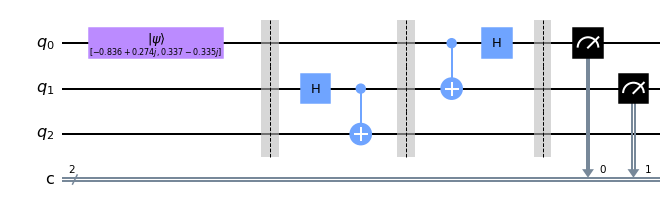

In [5]:
from qiskit import QuantumCircuit, assemble, Aer
import qiskit.quantum_info as qi
import numpy as np
import qiskit.quantum_info as qi
qc = QuantumCircuit(3,2)
qc.initialize(psi, 0) 
stv0 = qi.Statevector.from_instruction(qc)
qc.barrier()
qc.h(1) # Hadamard  
qc.cx(1,2) # CNOT 
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
stv = qi.Statevector.from_instruction(qc)
qc.measure(0,0)
qc.measure(1,1)
qc.draw("mpl")


The initial state of the 3 qubits is

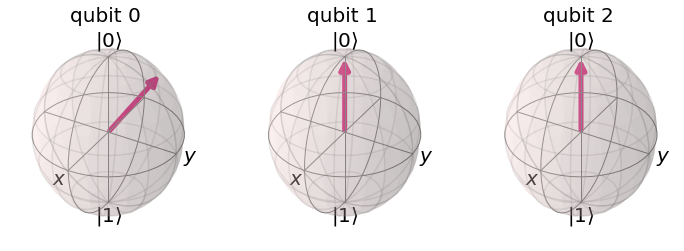

In [6]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(stv0)

We simulate the circuit once

{'11': 1}


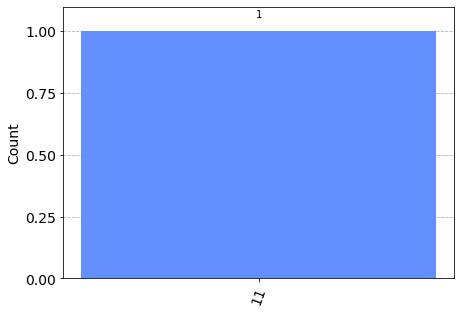

In [7]:
from qiskit import QuantumCircuit, Aer,execute
from qiskit.visualization import plot_histogram
backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc,backend, shots=1)
print(job.result().get_counts(qc))
plot_histogram(job.result().get_counts())

In [14]:
import qiskit.quantum_info as qi
import numpy as np
qc1 = QuantumCircuit(3,2)  
print(job.result().get_counts())
for key in job.result().data()["counts"]:
  if int(key,0) == 0 : 
    print("Result: 00")
    q2_state = [np.round(stv[0],3),np.round(stv[4],3)] 
    qc1.initialize(0, 0) 
    qc1.initialize(0, 1)   
  elif int(key,0) == 1 : 
    print("Result: 01")
    q2_state = [np.round(stv[1],3),np.round(stv[5],3)] 
    qc1.initialize(1, 0) 
    qc1.initialize(0, 1)    
  elif int(key,0) == 2 : 
    print("Result: 10")
    q2_state = [np.round(stv[2],3),np.round(stv[6],3)]
    qc1.initialize(0, 0) 
    qc1.initialize(1, 1)    
  elif int(key,0) == 3 : 
    print("Result: 11")
    q2_state = [np.round(stv[3],3),np.round(stv[7],3)]  
    qc1.initialize(1, 0) 
    qc1.initialize(1, 1)  
q2_normalizado = q2_state/np.linalg.norm(q2_state)
qc1.barrier()
qc1.initialize(q2_normalizado, 2) 
for key in job.result().data()["counts"]:
  if int(key,0) == 1 : 
    qc1.z(2)
  if int(key,0) == 2 : 
    qc1.x(2)
  if int(key,0) == 3 : 
    qc1.x(2)
    qc1.z(2)
  
stv1 = qi.Statevector.from_instruction(qc1)
stv1.draw('latex', prefix='Estado \quad del \quad qubit \quad 2 = ')

{'11': 1}
Result: 11


<IPython.core.display.Latex object>

The full quantum circuit is

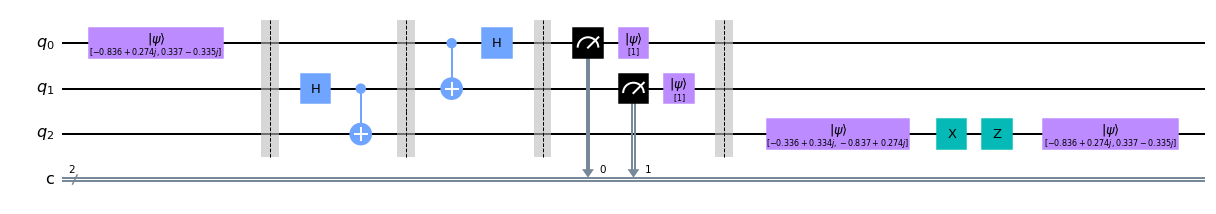

In [15]:
import qiskit.quantum_info as qi
import numpy as np
qc2 = QuantumCircuit(3,2) 
for key in job.result().data(qc)["counts"]:
  if int(key,0) != 0 : 
    qc2.initialize(psi, 2)
qcc = qc.compose(qc1)  
qc3 = qcc.compose(qc2) 

qc3.draw("mpl")

The final state of the 3 qubits is

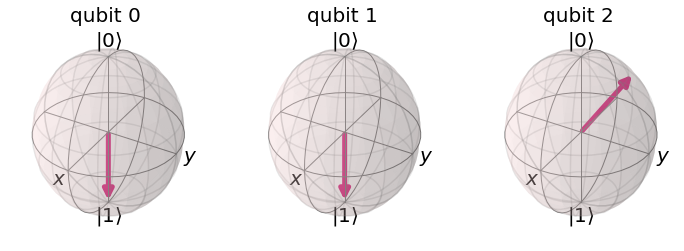

In [16]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(stv1)

# **2. Quantum Teleportation with Qiskit on a Simulated Noisy Quantum Computer**

We can get a list of the available quantum computers with

In [27]:
from qiskit import IBMQ
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
IBMQ.save_account('your-IBMQ-password',overwrite=True) # See https://quantum-computing.ibm.com/
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
     

ibmqfactory.load_account:WARNING:2023-02-23 16:24:25,588: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairo

We select a backend from the real computers of the IBM Quantum Experience. 


In [18]:
from qiskit_aer.noise import NoiseModel
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_manila')
noise_model = NoiseModel.from_backend(backend)
print("----------Noise Model for",backend,"--------------\n",noise_model)

ibmqfactory.load_account:WARNING:2023-02-23 16:20:03,888: Credentials are already in use. The existing account in the session will be replaced.


----------Noise Model for ibmq_manila --------------
 NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'id', 'cx', 'sx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


or we can select the least busy quantum computer with the following code:

In [19]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
print("----------Noise Model for",backend,"--------------\n",noise_model)

least busy backend:  ibmq_manila
----------Noise Model for ibmq_manila --------------
 NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'id', 'cx', 'sx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]




We will do the teleportation only when the 2 qubits measured by Alice result in 00 and we will ignore the 3  other cases.

The following circuit includes the random generation of the angles 
$\theta$ and $\phi$ for the qubit $|\psi\rangle$

$$
|\psi\rangle = \cos({\frac{\theta}{2}})|0\rangle +e^{i\phi} \sin({\frac{\theta}{2}})|1\rangle=\begin{pmatrix} \cos({\frac{\theta}{2}}) \\\\ e^{i\phi}\sin({\frac{\theta}{2}}) \end{pmatrix} 
$$

The unitary rotation operators


$$R_Y(\theta) = \exp\left(-i \frac{\theta}{2} Y\right) =
    \begin{pmatrix}
        \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
        \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
    \end{pmatrix}
$$

and

$$R_Z(\phi) = \exp\left(-i \frac{\phi}{2} Z\right) =
    \begin{pmatrix}
        e^{-i\phi/2} & 0 \\
       0 & e^{i\phi/2}
    \end{pmatrix}
$$



transform $|0\rangle$ in  $|\psi\rangle$ (up to a global phase) as shown below
$$
R_Z(\phi) R_Y(\theta) |0\rangle =\begin{pmatrix}
        e^{-i\phi/2} & 0 \\
       0 & e^{i\phi/2}
    \end{pmatrix}
\begin{pmatrix}
        \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
        \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
    \begin{pmatrix}1 \\\\ 0 \end{pmatrix} =
    \begin{pmatrix} e^{-i\phi/2}\cos{\frac{\theta}{2}} \\\\ e^{i\phi/2}\sin{\frac{\theta}{2}}  \end{pmatrix}
    =e^{-i\phi/2}|\psi\rangle
$$



theta = 0.98 rad,   theta = 56.43 degrees
phi= 5.3 rad,   phi = 303.43 degrees


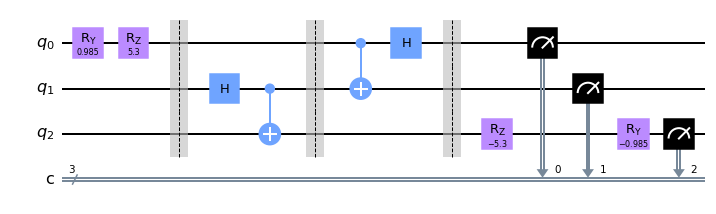

In [28]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit import IBMQ, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

import qiskit.quantum_info as qi
import numpy as np
import qiskit.quantum_info as qi
theta=np.pi*np.random.rand()
phi = 2*np.pi*np.random.rand()
print("theta =",np.round(theta,2),"rad,   theta =",np.round(180*theta/np.pi,2),"degrees")
print("phi=",np.round(phi,2),"rad,   phi =",np.round(180*phi/np.pi,2),"degrees")
qc = QuantumCircuit(3,3)
qc.ry(theta,0)
qc.rz(phi,0)
stv0 = qi.Statevector.from_instruction(qc)
qc.barrier()
qc.h(1) # Hadamard  
qc.cx(1,2) # CNOT 
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()

qc.rz(-phi,2)
qc.ry(-theta,2)
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.draw("mpl")

Right before measuring we apply the 2 unitary rotation operators to qubit 2 to undo the rotation that we applied initially to qubit 0. If the teleportation for the case that Alice measures $00$ is perfect then the final state of qubit 2 should be  $|0\rangle$.

The initial state of the 3 qubits is

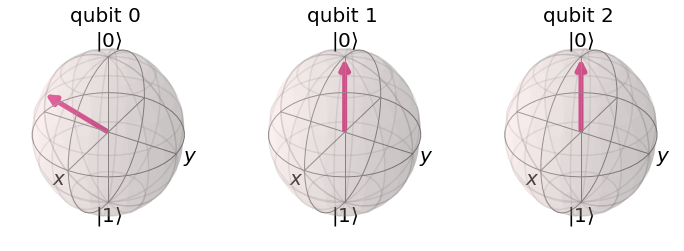

In [29]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(stv0)

We execute the circuit 1000 times but only the cases where Alice measures $00$ lead to teleportation and we ignore the other cases.


least busy backend:  aer_simulator(ibmq_manila)
Counts for teleportation with simulated noise model for ibmq_manila 




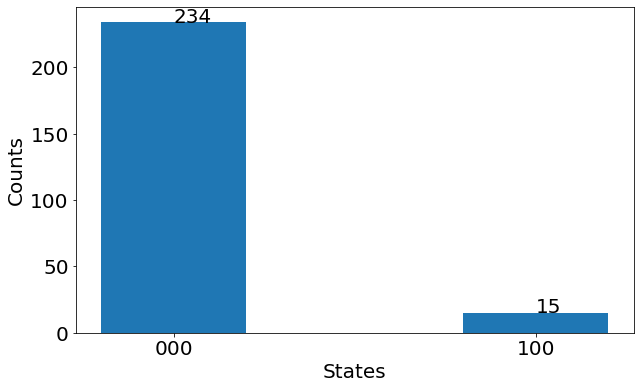

In [30]:
from qiskit import IBMQ, transpile
sim_backend = AerSimulator.from_backend(backend)
print("least busy backend: ", sim_backend)

# Transpile the circuit for the noisy basis gates
tqc = transpile(qc, sim_backend,optimization_level=3)

# Execute noisy simulation and get counts
job = sim_backend.run(tqc,shots=1000)
print("Counts for teleportation with simulated noise model for", backend,"\n\n")
try :
  n_error = job.result().get_counts(qc)['100']
except:
  n_error = 0
import matplotlib.pyplot as plt
try :
  n_error = job.result().get_counts(qc)['100']
except:
  n_error = 0
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))

states = ['000', '100']
counts = [job.result().get_counts(qc)['000'],n_error]
plt.rcParams.update({'font.size': 20})
plt.bar(states,counts,width=0.4, bottom=None,align='center', data=None)
for index, value in enumerate(counts):
    plt.text(index, value, str(value),fontsize=20)
plt.xlabel('States',fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.show()

We see that the teleportation fails in around 5% of the cases as evidenced by the small number of occurrences of the result $100$ which in the ideal situation should be 0

The transpiled circuit is the followng

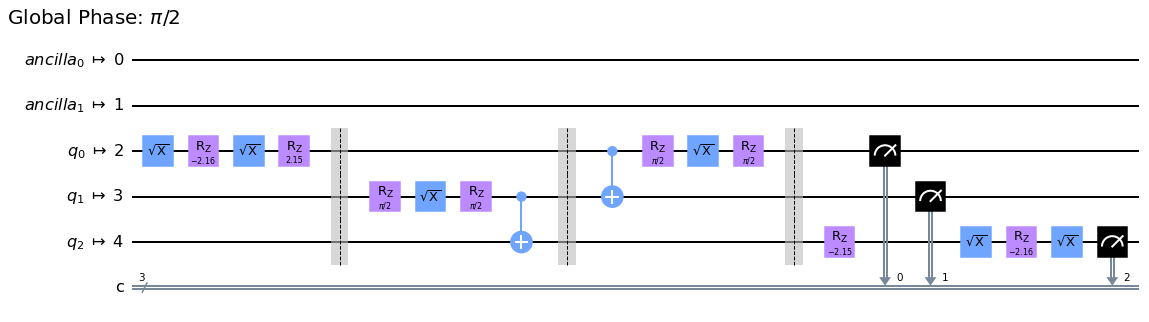

In [31]:
tqc.draw("mpl")

# **3. Quantum Teleportation with Qiskit on a Real Quantum Computer**

We select the least busy real computer available at the moment


In [32]:
from qiskit import IBMQ
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
print("----------Noise Model for",backend,"--------------\n",noise_model)

ibmqfactory.load_account:WARNING:2023-02-23 16:27:49,631: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila
----------Noise Model for ibmq_manila --------------
 NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'id', 'cx', 'sx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


The adapted quantum circuit as explained in the previous section is the following

theta = 1.75 rad,   theta = 100.41 degrees
phi= 4.9 rad,   phi = 280.7 degrees


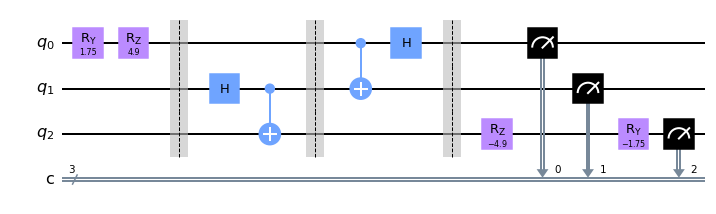

In [33]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

import qiskit.quantum_info as qi
import numpy as np
import qiskit.quantum_info as qi
theta=np.pi*np.random.rand()
phi = 2*np.pi*np.random.rand()
print("theta =",np.round(theta,2),"rad,   theta =",np.round(180*theta/np.pi,2),"degrees")
print("phi=",np.round(phi,2),"rad,   phi =",np.round(180*phi/np.pi,2),"degrees")
qc = QuantumCircuit(3,3)
qc.ry(theta,0)
qc.rz(phi,0)
stv0 = qi.Statevector.from_instruction(qc)
qc.barrier()
qc.h(1) # Hadamard  
qc.cx(1,2) # CNOT 
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()

qc.rz(-phi,2)
qc.ry(-theta,2)
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.draw("mpl")

The initial state of the 3 qubits is

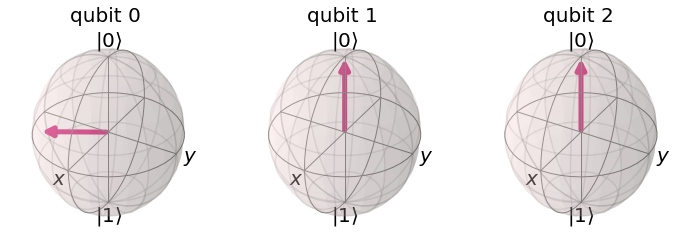

In [34]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(stv0)

We run the job on the selected backend 1000 times but only the cases where Alice measures $00$ lead to teleportation and we ignore the other cases.

In [40]:
from qiskit import IBMQ, transpile
tqc = transpile(qc, backend, optimization_level=3)
job_teleportation = backend.run(tqc,shots = 1000)

and monitor its execution with

In [47]:
print(job_teleportation.status(),job_teleportation.queue_position())

JobStatus.DONE None


once it finished we retrieve its results with

Counts for teleportation on ibmq_manila 




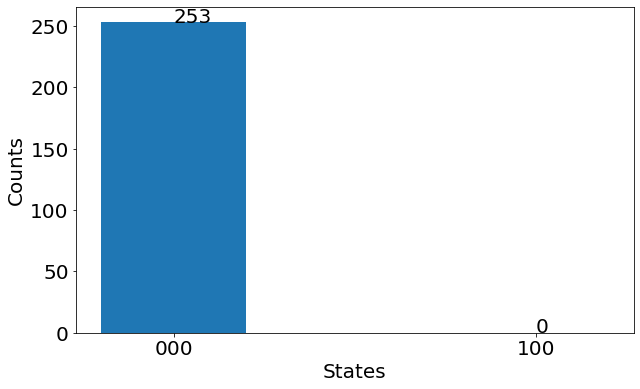

In [49]:
print("Counts for teleportation on", backend,"\n\n")
try :
  n_error = job.result().get_counts(qc)['100']
except:
  n_error = 0
import matplotlib.pyplot as plt
try :
  n_error = job.result().get_counts(qc)['100']
except:
  n_error = 0
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))

states = ['000', '100']
counts = [job_teleportation.result().get_counts(qc)['000'],n_error]
plt.rcParams.update({'font.size': 20})
plt.bar(states,counts,width=0.4, bottom=None,align='center', data=None)
for index, value in enumerate(counts):
    plt.text(index, value, str(value),fontsize=20)
plt.xlabel('States',fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.show()

We see that the teleportation on a real computer may or may not have errors which appear as a small number of occurrences of the state $100$ which in the ideal situation should be exactly 0.